In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pybenchfunction as bench

In [3]:
# Functions with sum of terms structure

def LevyN13_i(i,x):
    w = 1+(x-1)/4
    if i==0:
        return  torch.sin(torch.pi*w[0])**2
    else:
        return  ( (w[i-1]-1)**2*(1+10*torch.sin(torch.pi*w[i-1]+1)**2)+ (w[-1]-1)**2*(1+torch.sin(2*torch.pi*w[-1])**2)         )

def PermDBeta_i(i,x):
    beta=0.5  # Added default value for beta
    v = 0
    # j = np.arange(1, d+1)
    # j = range(1,d+1)
    # v = torch.sum(((j**(i+1) + beta) *((x/j)**(i+1) - 1))**2 ) 
    for j in range(d):
        # v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))   
        # v+=(1+j+beta)*(x[j]/(j+1)**(i+1))  
        v+= (((j+1)**(i+1) + beta) *((x[j]/(j+1))**(i+1) - 1))**2 
    return v

# def __call__(self, X):
#         d = X.shape[0]
#         j = np.arange(0, d)
#         res = np.sum([np.sum(((j+1)**(i+1) +(j+1)**(i)* self.beta) *((X/(j+1))**(i+1) - 1))**2  for i in range(0, d)])
#         return res

def Rastrigin_i(i,x):
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])
    return v
    
def RosenBrock_i(i,x):
    b = 100
    a = 1
    return b * (x[i] - x[i - 1] ** 2) ** 2 + (a - x[i]) ** 2   


In [4]:

def run_SP2plus(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = x0
    gdiffHvg = torch.zeros(d, requires_grad=False).double()*1
    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
            hessvgrad = torch.autograd.functional.hvp(funci, x, grad, create_graph=True)[1]
            # print(hessvgrad.shape)
            # hessian_grad = torch.autograd.grad(grads, self.params, grad_outputs=grads)
            with torch.no_grad():
                gradnormsqr = torch.norm(grad)**2
                if gradnormsqr > 1e-10:
                    sps_step = fi/gradnormsqr
                    x.sub_(sps_step*grad, alpha = lr)
                    # gdiffHvg = grad -hessvgrad*fi/gradnormsqr
                    gdiffHvg = torch.sub(grad, hessvgrad, alpha= sps_step)
                    # gdiffHvg = [g - fi*hg/gradnormsqr for g,hg in zip(grad, hessvgrad)]   # Maybe need this instead?
                    if torch.norm(gdiffHvg)**2 > 1e-10:
                        x.sub_(0.5*(sps_step**2)*gdiffHvg*torch.dot(grad,gdiffHvg)/ (torch.norm(gdiffHvg)**2), alpha = lr)
        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append([x[0].item(),x[1].item()])
        
    return x_list, fval


In [5]:
def plot_level_set_results(bench_function,x_list):
    bench.plot_2d(bench_function, n_space=100, ax=None, show=False)
    # bench.plot_3d(thevenot, n_space=100, ax=None,show=False)

    X_min, minimum = bench_function.get_global_minimum(2)
    plt.plot(X_min[0],X_min[1],'*', markersize=9, color='yellow')
    for x in x_list:
        plt.plot(x[0],x[1],'rs',markersize=4)
    plt.tight_layout()

    bench.plot_3d(bench_function, n_space=100, ax=None,show=False)
    plt.plot(X_min[0],X_min[1],'*', markersize=10, color='yellow')
    for x in x_list:
        plt.plot(x[0],x[1],'rs',markersize=4)
    plt.tight_layout()

  0%|          | 0/20 [00:00<?, ?it/s]

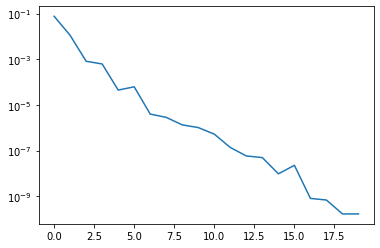

In [6]:
d=2
x_list, fval  =run_SP2plus(LevyN13_i, epochs=20, d=d)
plt.semilogy(fval)

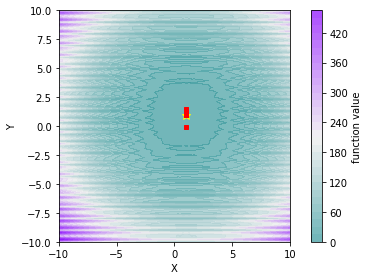

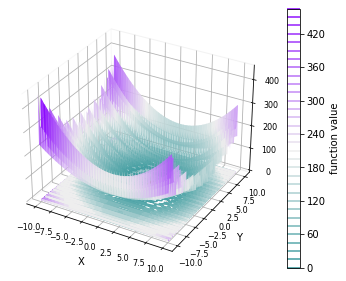

In [7]:
LevyN13 = bench.function.LevyN13(d)
plot_level_set_results(LevyN13,x_list)


  0%|          | 0/20 [00:00<?, ?it/s]

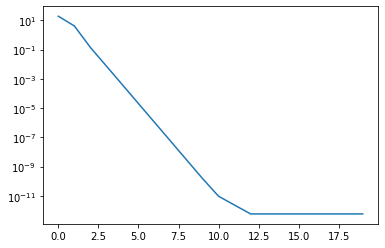

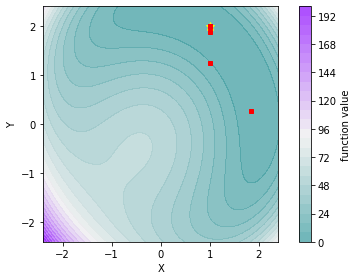

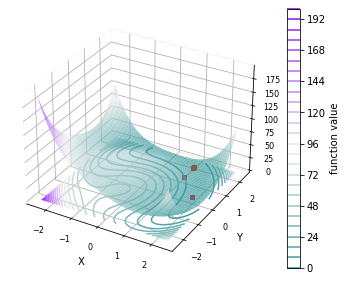

In [8]:
d=2
x0 = -2*torch.randn(d, requires_grad=True).double()
x_list, fval  =run_SP2plus(PermDBeta_i, epochs=20, d=d, x0 =x0, lr = 1.0)
plt.semilogy(fval)


PermDBeta = bench.function.PermDBeta(d)
plot_level_set_results(PermDBeta,x_list)

  0%|          | 0/500 [00:00<?, ?it/s]

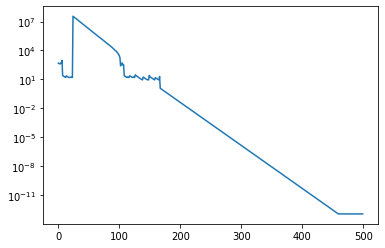

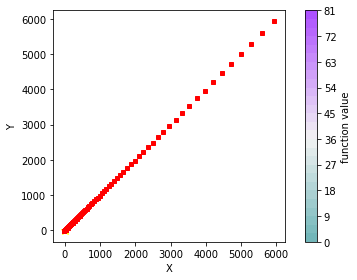

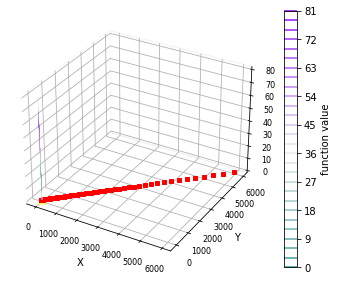

In [9]:
d=2
x0 = torch.ones(d, requires_grad=True).double() *0.5
x_list, fval  =run_SP2plus(Rastrigin_i, epochs=500, d=d, x0 =x0, lr = 0.1)
plt.semilogy(fval)

Rastrigin = bench.function.Rastrigin(d)
plot_level_set_results(Rastrigin,x_list)

  0%|          | 0/500 [00:00<?, ?it/s]

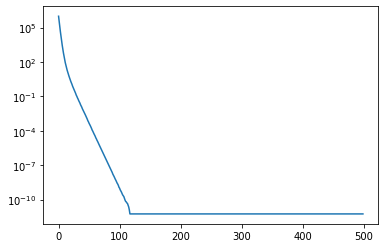

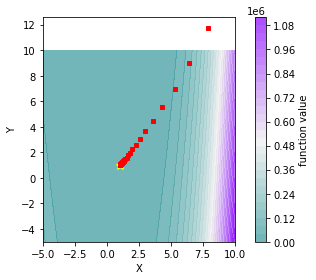

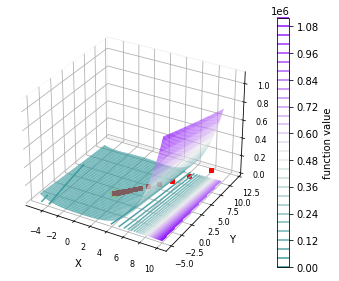

In [10]:
d=2
x0 = torch.rand(d, requires_grad=True)*20
x_list, fval  =run_SP2plus(RosenBrock_i, epochs=500, d=d, x0 =x0, lr = 1.0)
plt.semilogy(fval)

Rosenbrock = bench.function.Rosenbrock(d)
plot_level_set_results(Rosenbrock,x_list)
